<a href="https://colab.research.google.com/github/John260260/Deep_Learning/blob/main/Twitter_sentiment_analysis_NLP_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re
import random

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.8.0


In [3]:
df=pd.read_csv('/content/drive/MyDrive/datasets/training.1600000.processed.noemoticon.csv',encoding = 'latin',header=None)

In [4]:
df.shape

(1600000, 6)

In [5]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
df.columns=['sentiment','id','date','query','user_id','text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
df=df.drop(['id','date','query','user_id'],axis=1)

In [8]:
df.columns

Index(['sentiment', 'text'], dtype='object')

In [9]:
df.sentiment.value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

In [10]:
df['sentiment']=df.sentiment.map({0:'Negative',4:'Positive'})
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


In [11]:
val_count=df.groupby('sentiment').count()

In [12]:
val_count.index.values

array(['Negative', 'Positive'], dtype=object)

In [13]:
val_count['text']

sentiment
Negative    800000
Positive    800000
Name: text, dtype: int64

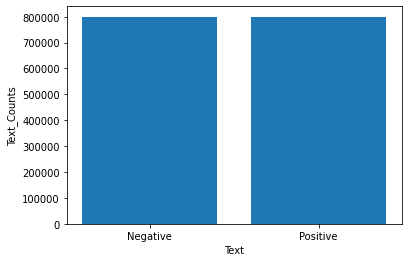

In [14]:
val_count=df.groupby('sentiment').count()
plt.bar(val_count.index.values, val_count['text'])
plt.xlabel('Text')
plt.ylabel('Text_Counts')
plt.show()

In [15]:
df.iloc[799995:800005]

,sentiment,text
799995,Negative,Sick Spending my day laying in bed listening ...
799996,Negative,Gmail is down?
799997,Negative,rest in peace Farrah! So sad
799998,Negative,@Eric_Urbane Sounds like a rival is flagging y...
799999,Negative,has to resit exams over summer... wishes he w...
800000,Positive,I LOVE @Health4UandPets u guys r the best!!
800001,Positive,im meeting up with one of my besties tonight! ...
800002,Positive,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,Positive,Being sick can be really cheap when it hurts t...
800004,Positive,@LovesBrooklyn2 he has that effect on everyone


In [16]:
# creates random indexes to choose from dataframe
random_idx_list=[random.randint(1,len(df.text)) for i in range(10)]
df.loc[random_idx_list,:].head(10)

,sentiment,text
170629,Negative,"@BabyStowz yea, feel like im bein ignored"
631401,Negative,Oh shoot !!! I didn't know Kobe was in Disneyl...
200062,Negative,"@LimeIce .. one day, you're gonna be a &lt;yo..."
866872,Positive,local bike shop to the rescue! changing a bott...
1455457,Positive,Defnitely. You have a good night/morning as we...
1109454,Positive,just finished eating my dinner. im full! HAHA....
1591182,Positive,Father's Day....Aww I miss my dad. Happy Fathe...
67791,Negative,so i have to go to the police station tomorrow...
163614,Negative,"Omg, I'm a murdere! I accidently just killed a..."
232277,Negative,@TachaV I'm bored as shit and hungry as hell


In [17]:
#shuffle data and reindex
df2=df.sample(frac=1).reset_index(drop=True)
df2.head()

,sentiment,text
0,Positive,@CherylH77 ah ok... ta
1,Negative,@jmao311 @GarberIsRad the bumblebee tuna comme...
2,Negative,@LemonpiY i'd be willing to try the ants right...
3,Negative,i miss zack. i miss him. can june 13th please...
4,Negative,@erica_richard I was supposed to sing at a chu...


In [18]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [19]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [20]:
df.text = df.text.apply(lambda x: preprocess(x))

In [21]:
df.text.head()

0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2    dived many times ball managed save 50 rest go ...
3                     whole body feels itchy like fire
4                                     behaving mad see
Name: text, dtype: object

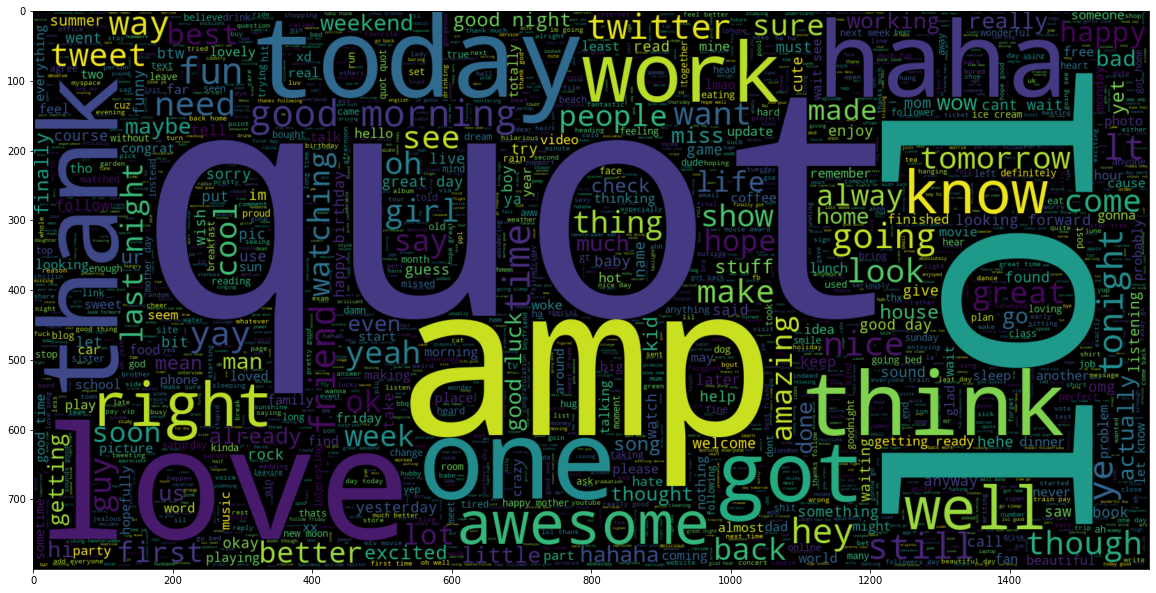

In [22]:
from wordcloud import WordCloud
#the more a specific word appear in a source of data (such as a speech, blog post, or database), the bigger and bolder it appears in the word cloud.

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

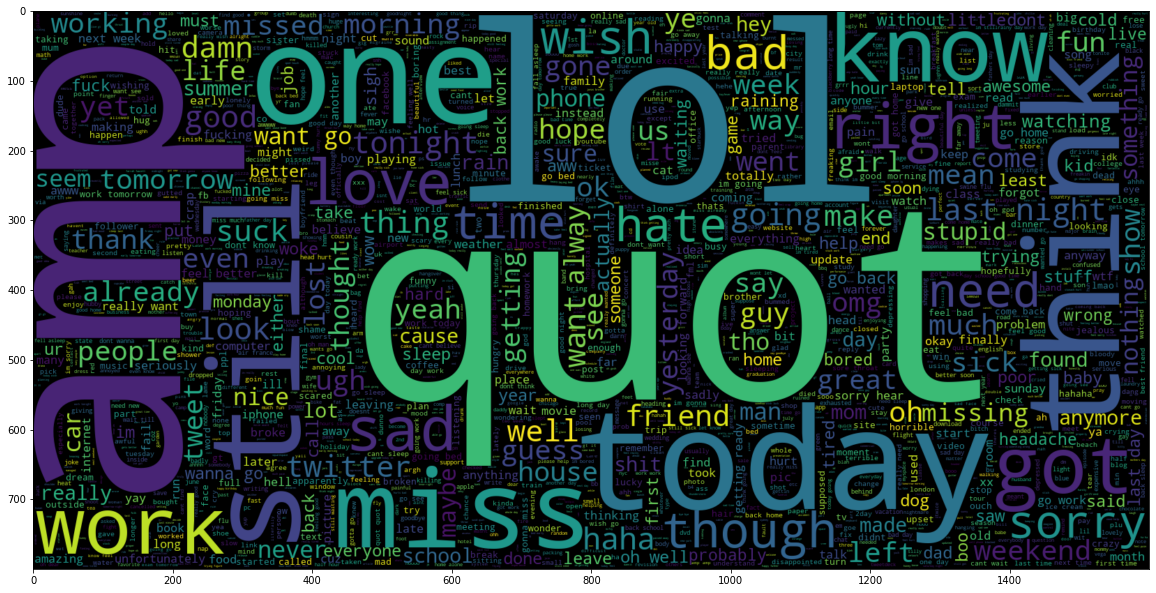

In [23]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [24]:
TRAIN_SIZE=0.8
MAX_NB_WORDS=100000
MAX_SEQUENCE_LENGTH=30

In [25]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,random_state=7)
print('Train_Data_Size', len(train_data))
print('Test_Data_Size', len(test_data))

Train_Data_Size 1280000
Test_Data_Size 320000


In [26]:
train_data.shape

(1280000, 2)

In [27]:
test_data.shape

(320000, 2)

In [28]:
train_data.head(10)

,sentiment,text
23786,Negative,need friends
182699,Negative,im trying call impossible
476661,Negative,good pace going 3k 13 min missed 5k turn ended...
1181490,Positive,u gonna shows ny soon luv see u live
878773,Positive,hell yea get em tattoos ink free wish parents ...
130866,Negative,yeah need 2 see ur mom calls back first rememb...
1235876,Positive,sounds like cup tea sign
717314,Negative,tired want sleep wtf
969880,Positive,amazing wish
748698,Negative,thank god wkrn abc affiliate nashville back mi...


tokenizer create tokens for every word in the data corpus and map them to a index using dictionary.

word_index contains the index for each word

vocab_size represents the total number of word in the data corpus

In [29]:
from keras.preprocessing.text import Tokenizer 

In [30]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index=tokenizer.word_index
vocab_size=len(tokenizer.word_index)+1
print('Vocabulary_size', vocab_size)

Vocabulary_size 290575


Now we got a tokenizer object, which can be used to covert any word into a Key in dictionary (number).

Since we are going to build a sequence model. We should feed in a sequence of numbers to it. And also we should ensure there is no variance in input shapes of sequences. It all should be of same lenght. But texts in tweets have different count of words in it. To avoid this, we seek a little help from pad_sequence to do our job. It will make all the sequence in one constant length MAX_SEQUENCE_LENGTH.

In [31]:
from keras.preprocessing.sequence import pad_sequences

x_train=pad_sequences(tokenizer.texts_to_sequences(train_data.text),maxlen=MAX_SEQUENCE_LENGTH)
x_test=pad_sequences(tokenizer.texts_to_sequences(test_data.text),maxlen=MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [32]:
labels=train_data.sentiment.unique().tolist()
labels

['Negative', 'Positive']

Encoder

In [33]:
encoder=LabelEncoder()
encoder.fit(train_data.sentiment.tolist())

y_train=encoder.transform(train_data.sentiment.tolist())
y_test=encoder.transform(test_data.sentiment.tolist())

y_train.reshape(-1,1)
y_test.reshape(-1,1)

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [34]:
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000,)
y_test shape: (320000,)


Word Emdedding
In Language Model, words are represented in a way to intend more meaning and for learning the patterns and contextual meaning behind it.

Word Embedding is one of the popular representation of document vocabulary.It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Basically, it's a feature vector representation of words which are used for other natural language processing applications.

We could train the embedding ourselves but that would take a while to train and it wouldn't be effective. So going in the path of Computer Vision, here we use Transfer Learning. We download the pre-trained embedding and use it in our model.

The pretrained Word Embedding like GloVe & Word2Vec gives more insights for a word which can be used for classification.

In this notebook, I use GloVe Embedding from Stanford AI 

In [35]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-03-07 16:02:26--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-07 16:02:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-07 16:02:27--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [36]:
GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [37]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [38]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [39]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,EMBEDDING_DIM,weights=[embedding_matrix],
                                            input_length=MAX_SEQUENCE_LENGTH,trainable=False)

In [40]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [41]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

Optimization Algorithm
This notebook uses Adam, optimization algorithm for Gradient Descent. You can learn more about Adam here

Callbacks
Callbacks are special functions which are called at the end of an epoch. We can use any functions to perform specific operation after each epoch. I used two callbacks here,

LRScheduler - It changes a Learning Rate at specfic epoch to achieve more improved result. In this notebook, the learning rate exponentionally decreases after remaining same for first 10 Epoch.

ModelCheckPoint - It saves best model while training based on some metrics. Here, it saves the model with minimum Validity Loss.

In [42]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,min_lr = 0.01,monitor = 'val_loss',verbose = 1)    

In [43]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 254s 190ms/step - loss: 0.5195 - accuracy: 0.7392 - val_loss: 0.4832 - val_accuracy: 0.7657 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 234s 187ms/step - loss: 0.4882 - accuracy: 0.7618 - val_loss: 0.4741 - val_accuracy: 0.7720 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 234s 187ms/step - loss: 0.4780 - accuracy: 0.7686 - val_loss: 0.4674 - val_accuracy: 0.7761 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 233s 186ms/step - loss: 0.4717 - accuracy: 0.7725 - val_loss: 0.4642 - val_accuracy: 0.7777 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 234s 187ms/step - loss: 0.4674 - accuracy: 0.7753 - val_loss: 0.4651 - val_accuracy: 0.7780 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - 235s 188ms/step - loss: 0.4637 - accuracy: 0.7775 - val_loss: 0.4606 - val_accuracy: 0.7795 - lr: 0.0010
Epoch 7/10
1250/1250 [============

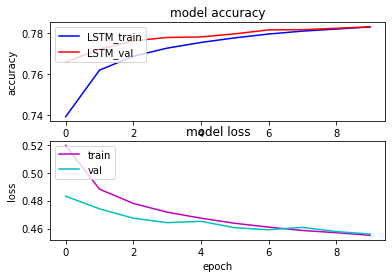

In [44]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [45]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 6s 128ms/step


In [46]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.78      0.79      0.78    160542
    Positive       0.79      0.78      0.78    159458

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000

